In [1]:
%matplotlib inline

In [32]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%%bash
cd data
ls

survey_results_public.csv
survey_results_schema.csv


In [4]:
%%bash
ls

README.md
SO_notebook_2.ipynb
data


In [5]:
df1 = pd.read_csv('data/survey_results_schema.csv')

In [120]:
df2 = pd.read_csv('data/survey_results_public.csv') #Check warning

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
print(df1.shape)
print(df2.shape)

(129, 2)
(98855, 129)


In [8]:
df1

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,Hobby,Do you code as a hobby?
2,OpenSource,Do you contribute to open source projects?
3,Country,In which country do you currently reside?
4,Student,"Are you currently enrolled in a formal, degree..."
5,Employment,Which of the following best describes your cur...
6,FormalEducation,Which of the following best describes the high...
7,UndergradMajor,You previously indicated that you went to a co...
8,CompanySize,Approximately how many people are employed by ...
9,DevType,Which of the following describe you? Please se...


<Container object of 2 artists>

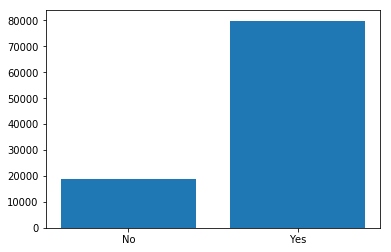

In [9]:
#Hobby Coders
plt.figure(1)
for_plot = df2.groupby(["Hobby"]).size()
for_plot = for_plot.reset_index()
plt.bar(x = for_plot["Hobby"] , height = for_plot[0])

<Container object of 2 artists>

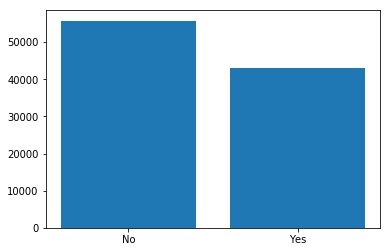

In [10]:
#Open Sources
plt.figure(1)
for_plot = df2.groupby(["OpenSource"]).size()
for_plot = for_plot.reset_index()
plt.bar(x = for_plot["OpenSource"] , height = for_plot[0])

<Container object of 2 artists>

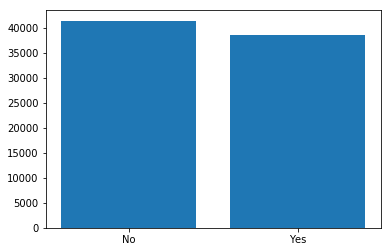

In [100]:
#Of the hobbyisits how many open sourcers and how many not?? ... Hmm not much of difference
plt.figure(1)
for_plot = df2[df2['Hobby'] == "Yes"]
for_plot = for_plot.groupby(["OpenSource"]).size()
for_plot = for_plot.reset_index()
plt.bar(x = for_plot["OpenSource"] , height = for_plot[0])

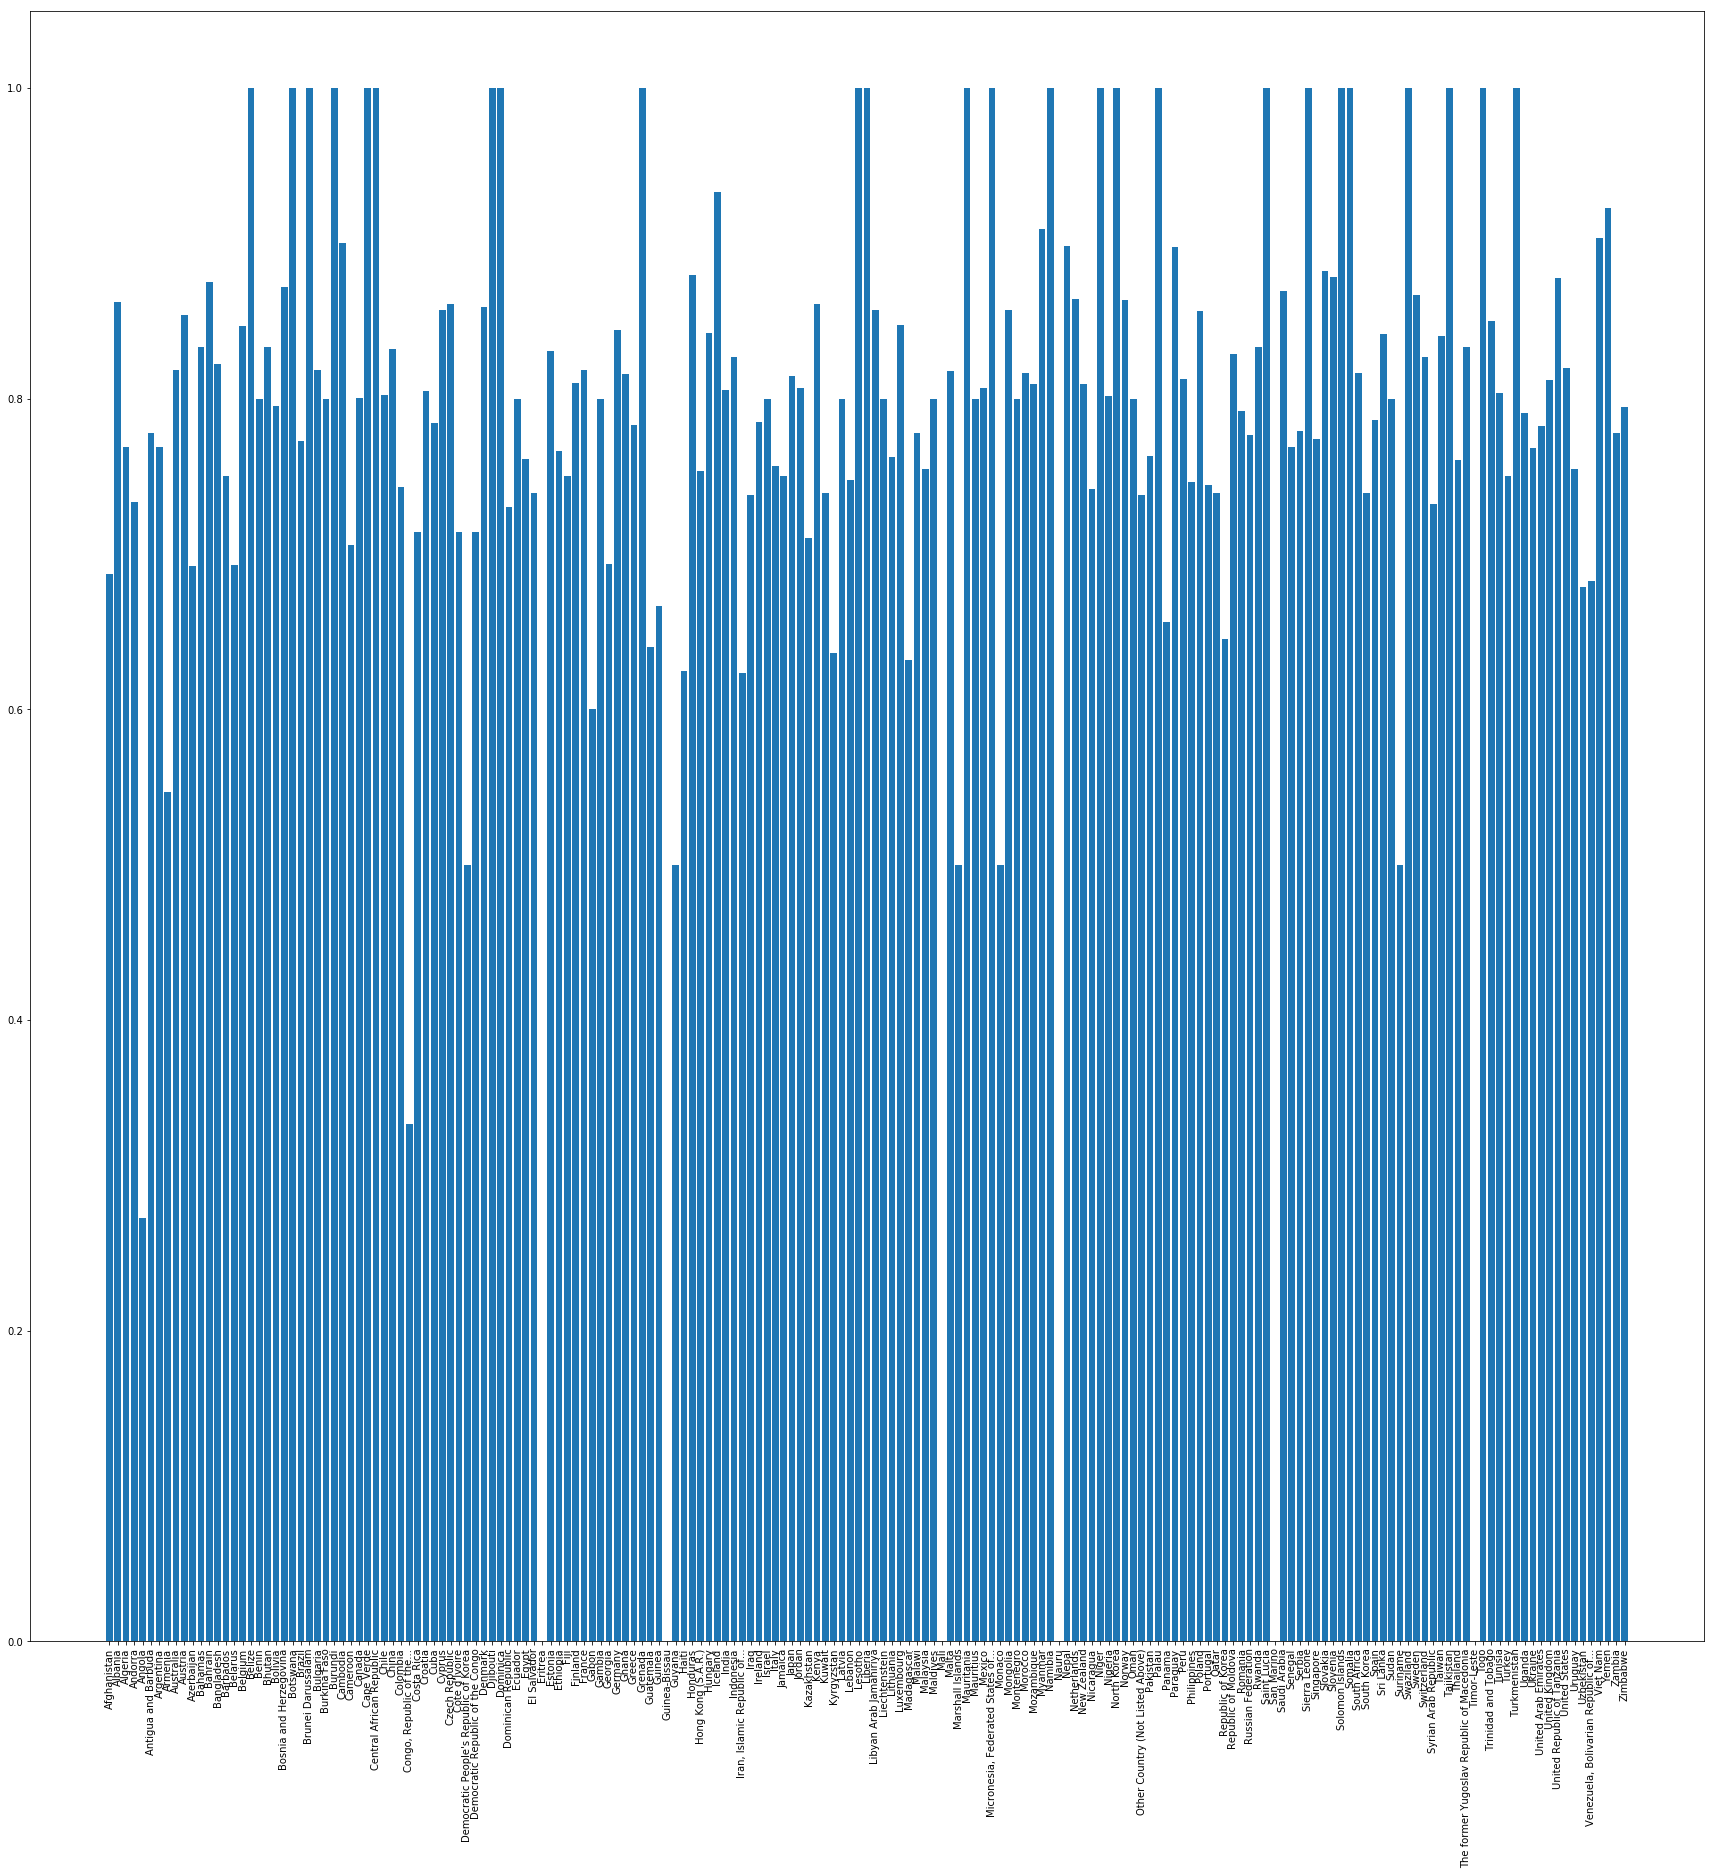

In [121]:
#Where do the most hobbyists come from and non_hobbyists?? ,,, what about zero hobby countries
for_plot = df2
for_plot["Hobby"] = for_plot["Hobby"].map({'Yes': 1, 'No': 0})
for_plot = for_plot.groupby(['Country']).agg({'Hobby':np.mean})
for_plot = for_plot.reset_index()
plt.figure(1 , figsize = (30,30))#This can be converted into geographical plot.
plt.bar(x = for_plot["Country"],height = for_plot["Hobby"])
plt.xticks(rotation = 90)
plt.show()

In [96]:
for_plot["Hobby"][52]

0.0

In [13]:
#We need concentrate on 101 to 116 for the task, as to identify participation/involvement 
#in community according to the objective we need to map relevant columns like, Sex, Country, Job_descreption to these
df1.loc[101:116]

,Column,QuestionText
101,StackOverflowRecommend,How likely is it that you would recommend Stac...
102,StackOverflowVisit,How frequently would you say you visit Stack O...
103,StackOverflowHasAccount,Do you have a Stack Overflow account?
104,StackOverflowParticipate,How frequently would you say you participate i...
105,StackOverflowJobs,Have you ever used or visited Stack Overflow J...
106,StackOverflowDevStory,Do you have an up-to-date Developer Story on S...
107,StackOverflowJobsRecommend,How likely is it that you would recommend Stac...
108,StackOverflowConsiderMember,Do you consider yourself a member of the Stack...
109,HypotheticalTools1,Please rate your interest in participating in ...
110,HypotheticalTools2,Please rate your interest in participating in ...


In [14]:
df2.columns.values

array(['Respondent', 'Hobby', 'OpenSource', 'Country', 'Student',
       'Employment', 'FormalEducation', 'UndergradMajor', 'CompanySize',
       'DevType', 'YearsCoding', 'YearsCodingProf', 'JobSatisfaction',
       'CareerSatisfaction', 'HopeFiveYears', 'JobSearchStatus',
       'LastNewJob', 'AssessJob1', 'AssessJob2', 'AssessJob3',
       'AssessJob4', 'AssessJob5', 'AssessJob6', 'AssessJob7',
       'AssessJob8', 'AssessJob9', 'AssessJob10', 'AssessBenefits1',
       'AssessBenefits2', 'AssessBenefits3', 'AssessBenefits4',
       'AssessBenefits5', 'AssessBenefits6', 'AssessBenefits7',
       'AssessBenefits8', 'AssessBenefits9', 'AssessBenefits10',
       'AssessBenefits11', 'JobContactPriorities1',
       'JobContactPriorities2', 'JobContactPriorities3',
       'JobContactPriorities4', 'JobContactPriorities5',
       'JobEmailPriorities1', 'JobEmailPriorities2',
       'JobEmailPriorities3', 'JobEmailPriorities4',
       'JobEmailPriorities5', 'JobEmailPriorities6',
       'JobE

In [45]:
#Lets concentrate on self taught types
df2["SelfTaughtTypes"].isnull().sum()
self_taught = df2[-df2["SelfTaughtTypes"].isnull()]

In [46]:
#Counting how many sources self_taughts learn from 
self_taught["no_of_sources"] = self_taught["SelfTaughtTypes"].str.split(';').apply(lambda x : len(x))

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


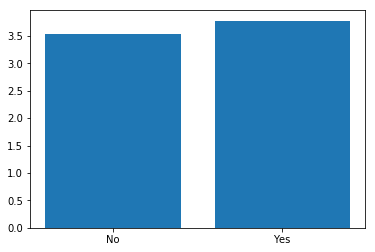

In [77]:
#Not much of a difference, is it??
for_plot = self_taught.groupby(["Hobby"]).agg({'no_of_sources': np.mean})
for_plot = for_plot.reset_index()
for_plot.head()
plt.figure(1)
axes = plt.subplot(111)
plt.bar(x = pd.Categorical(for_plot["Hobby"]) , height = for_plot["no_of_sources"])
plt.xticks([0,1])
a=axes.get_xticks().tolist()
a[0] = "No"
a[1] = "Yes"
axes.set_xticklabels(a)
plt.show()

In [82]:
#Lets filter out people who have Stackoverflow in their learning sources
stack_learners = df2[-df2["SelfTaughtTypes"].isnull()]
stack_learners = stack_learners[stack_learners["SelfTaughtTypes"].str.contains("Stack Overflow")]

In [84]:
stack_learners.shape[0]/df2.shape[0] #Pretty impressive 52% question respondents, but wait...how did non-users get to know about survey

0.5210156289514946

In [ ]:
#Which country has most mean stack_learners
